In [109]:
# Import modules
import json
import csv
import math


from textwrap import wrap
import itertools 
from itertools import combinations

# Classic analysis imports
import numpy as np 
import pandas as pd 
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns

# Geopandsa
import geopandas as gpd
from shapely.geometry import JOIN_STYLE, Polygon, MultiPolygon
# Stat analysis import 
from sklearn import preprocessing
from sklearn.cluster import KMeans


import scipy 
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from statsmodels.sandbox.stats.multicomp import multipletests

import scikit_posthocs as sp

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.stattools as stools

import statsmodels.stats as stats 

from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.anova import anova_lm

from statsmodels.stats import multicomp as mc
from statsmodels.miscmodels.ordinal_model import OrderedModel

#from pymer4.models import Lmer

#import pingouin as pg

# options for the notebook
pd.set_option('display.max_colwidth',1000)
plt.style.use('seaborn')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [5, 5]

#%load_ext rpy2.ipython

In [67]:
from scipy.stats import chi2_contingency
from scipy.stats import norm
def chisq_posthoc_corrected(cross_table, correction_method='bonferroni', alpha=.05):
    """
    Get crosstab dataframe and do a chisquared test followed with the post-hoc with analysis of adjusted residuals
    source: https://colab.research.google.com/drive/1QIDHMvpDq7Max5hk2mozSFdVssavdV-I#scrollTo=ig1kdg40qLDH
    source: https://github.com/neuhofmo/chisq_test_wrapper
    """
    def get_asterisks_for_pval(p_val, alpha=0.05):
        """Receives the p-value and returns asterisks string."""
        if p_val > alpha:  # bigger than alpha
            p_text = "ns"
        # following the standards in biological publications
        elif p_val < 1e-4:  
            p_text = '****'
        elif p_val < 1e-3:
            p_text = '***'
        elif p_val < 1e-2:
            p_text = '**'
        else:
            p_text = '*'
    
        return p_text  # string of asterisks
    
    chiVal, pVal, df, exp = chi2_contingency(cross_table)

    colTotals = cross_table.sum()
    nCols = len(colTotals)
    rowTotals = cross_table.sum(axis=1)
    nRows = len(rowTotals)
    n = sum(rowTotals)
    print("Chi2 result of the contingency table: {}, p-value: {}, dof: {}, N: {}\n".format(chiVal, pVal, df, n))

    
    for i in range(nRows):
        for j in range(nCols):
            AdjRes = (cross_table.iloc[i,j] - exp[i,j]) / (exp[i,j]*(1-rowTotals[i]/n)*(1-colTotals[j]/n))**0.5            
    phRes = pd.DataFrame(columns=[cross_table.index.name, cross_table.columns.name, 'Adj. Res.'])
    for i in range(nRows):
        for j in range(nCols):
            AdjRes = (cross_table.iloc[i,j] - exp[i,j]) / (exp[i,j]*(1-rowTotals[i]/n)*(1-colTotals[j]/n))**0.5
            phRes = phRes.append({cross_table.index.name:cross_table.index[i], cross_table.columns.name:cross_table.columns[j], 'Adj. Res.':AdjRes}, ignore_index=True)
    phRes['p_value'] = 2*(1-norm.cdf(abs(phRes['Adj. Res.'])))
    # Bonferroni correction
  
    reject_list, corrected_p_vals = multipletests(phRes['p_value'], method=correction_method, alpha=alpha)[:2]
    
    phRes['p_value_corrected'] = corrected_p_vals
    phRes['reject'] = reject_list
    ast = []
    for p_vals in corrected_p_vals:
        ast.append(get_asterisks_for_pval(p_vals))
    phRes['asterisques'] = ast

    return phRes


In [68]:
# Source: https://medium.com/analytics-vidhya/create-your-own-coefficient-plot-function-in-python-aadb9fe27a77
# Define function to output plot of the model coefficients

def coefplot(results):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    coef_df = coef_df.drop(['const'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar',
                 ax=ax, color='none', fontsize=22, 
                 ecolor='steelblue',capsize=0,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
    ax.set_ylabel('Coefficients',fontsize=22)
    ax.set_xlabel('',fontsize=22)
    
    # Coefficients
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['coef'], color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    return plt.show()

In [69]:
# Setting up the folders 
data_folder = "../data/"
analysis_results_folder = "../results/"
plots_folders = "../plots"

# Filenames
dataset_clean_filename = 'cleaned_dataset_per_subject.csv'

dataset_news_full_filename = 'cleaned_dataset_per_news.csv'

df_subject = pd.read_csv('{}{}'.format(data_folder, dataset_clean_filename))
df_news = pd.read_csv('{}{}'.format(data_folder, dataset_news_full_filename))
# Fix some variable for later analysis
#df_news['answer'] = df_news['answer'].astype('category') # Transform answer as factor
#df_news['id_sondea'] = df_news['id_sondea'].astype(str) # Transform id_sondea as str for transforming into category later
df_news

,reread_true,date_arrive,date_finish,state,time,id_sondea,id_sondea_valid,dm_genero,dm_edad,dm_provincia,...,Other,Previously_read_the_information,Known_media,Reliable_media,Source_known,Source_Reliable,Professional_style,Coherent,Same_belief,Same_ideology
0,False,2021-03-17 14:04:13.103024+00:00,2021-03-17 14:10:39.487599+00:00,result,6.43,610,NaN,Female,55-65 años,Madrid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,False,2021-03-15 20:16:10.657700+00:00,2021-03-15 20:18:37.196160+00:00,result,2.45,2006,NaN,Female,> 65 años,Barcelona,...,NaN,False,False,True,False,False,False,False,False,False
2,True,2021-03-17 12:49:33.008115+00:00,2021-03-17 13:14:09.004934+00:00,result,43.65,2266,NaN,Male,> 65 años,Sevilla,...,NaN,False,False,False,True,True,False,True,False,False
3,False,2021-03-16 16:44:06.670711+00:00,2021-03-16 16:49:18.354946+00:00,result,5.20,2331,NaN,Male,45-54 años,Santa Cruz de Tenerife,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,False,2021-03-16 14:30:01.034250+00:00,2021-03-16 14:46:49.878175+00:00,result,25.03,2548,NaN,Female,> 65 años,Málaga,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,False,2021-03-16 19:20:52.298465+00:00,2021-03-16 19:31:47.791384+00:00,result,10.92,1814722,NaN,Female,55-65 años,Málaga,...,NaN,False,False,False,False,False,True,False,True,False
1676,True,2021-03-17 12:50:51.163218+00:00,2021-03-17 12:55:18.971982+00:00,result,4.45,1814733,NaN,Female,25-34 años,Barcelona,...,NaN,True,False,False,False,False,False,False,False,False
1677,True,2021-03-17 12:40:25.871131+00:00,2021-03-17 12:52:18.090159+00:00,result,11.88,1814744,NaN,Male,> 65 años,Castelló,...,NaN,False,True,False,True,False,False,False,False,False
1678,False,2021-03-17 16:30:57.573534+00:00,2021-03-17 16:34:54.083662+00:00,result,3.95,1814761,NaN,Female,35-44 años,A Coruña,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
df_subject.dm_provincia.value_counts()

Madrid                     105
Barcelona                   93
València                    57
Sevilla                     49
Alacant                     35
A Coruña                    30
Asturias                    28
Málaga                      26
Zaragoza                    25
Cádiz                       22
Bizkaia                     22
Pontevedra                  21
Castelló                    18
Murcia                      17
Badajoz                     17
Valladolid                  16
Granada                     16
Las Palmas                  16
Santa Cruz de Tenerife      15
Cantabria                   15
Almería                     15
Navarra                     14
Balears / Illes Balears     14
Araba                       13
Toledo                      11
Cáceres                     10
Salamanca                   10
Burgos                       9
Córdoba                      8
Jaén                         8
Girona                       8
Guadalajara                  7
León    

## load the Spanish shapefile into geopandas

In [124]:
spain_map = gpd.read_file('./Spain_shapefile/INE_2011/SECC_CPV_E_20111101_01_R_INE.shp')


,OBJECTID,CUSEC,CUMUN,CSEC,CDIS,CMUN,CPRO,CCA,CUDIS,OBS,...,CNUT2,CNUT3,CLAU2,NPRO,NCA,NMUN,Shape_Leng,Shape_area,Shape_len,geometry
0,1,0100101001,01001,001,01,001,01,16,0100101,None,...,1,1,01001,Araba/Álava,País Vasco,Alegría-Dulantzi,34474.734278,1.551393e+07,34474.734278,"MULTIPOLYGON (((541571.209 4745050.120, 541581.897 4745049.620, 541581.969 4745049.620, 541589.901 4745049.620, 541589.972 4745049.618, 541604.462 4745049.120, 541606.522 4745048.616, 541606.594 4745048.616, 541610.463 4745048.616, 541610.534 4745048.616, 541614.272 4745048.616, 541614.343 4745048.616, 541632.534 4745046.614, 541663.970 4745043.116, 541675.722 4745041.614, 541678.159 4745041.114, 541701.907 4745038.615, 541704.582 4745038.615, 541704.654 4745038.615, 541708.657 4745038.116, 541712.909 4745037.616, 541719.594 4745036.616, 541731.656 4745035.117, 541734.649 4745035.117, 541734.720 4745035.117, 541738.656 4745034.613, 541774.592 4745030.614, 541776.270 4745030.614, 541776.341 4745030.614, 541777.593 4745030.115, 541779.028 4745029.113, 541783.470 4745025.113, 541809.717 4745002.114, 541811.969 4745000.615, 541812.657 4744999.615, 541813.907 4744998.612, 541816.782 4744996.113, 541821.595 4744992.115, 541833.968 4744981.113, 541838.032 4744977.611, 541843.844 4744972.6..."
1,2,0100101002,01001,002,01,001,01,16,0100101,None,...,1,1,01001,Araba/Álava,País Vasco,Alegría-Dulantzi,8620.042319,4.410972e+06,8620.042319,"POLYGON ((541370.963 4745058.623, 541371.018 4745058.619, 541371.042 4745058.617, 541384.713 4745057.623, 541384.784 4745057.623, 541386.462 4745057.623, 541386.533 4745057.623, 541391.586 4745057.623, 541377.834 4744974.792, 541377.832 4744885.533, 541387.480 4744801.099, 541435.726 4744709.427, 541476.735 4744644.292, 541500.857 4744576.745, 541510.505 4744504.373, 541491.204 4744427.177, 541452.604 4744359.630, 541409.180 4744321.033, 541346.457 4744282.436, 541286.147 4744251.076, 541211.361 4744207.655, 541141.401 4744173.883, 541076.265 4744108.750, 541032.840 4744053.265, 540994.241 4744002.606, 540948.404 4743949.534, 540870.764 4743903.768, 540712.664 4743820.770, 540406.344 4743668.606, 540365.831 4743652.797, 540332.234 4743636.000, 540320.377 4743627.107, 540307.531 4743615.250, 540285.792 4743619.203, 540273.935 4743607.346, 540260.100 4743581.655, 540236.385 4743545.095, 540206.741 4743519.405, 540176.108 4743488.774, 540120.773 4743447.274, 540076.307 4743412.691, 54..."
2,3,0100201001,01002,001,01,002,01,16,0100201,None,...,1,1,01002,Araba/Álava,País Vasco,Amurrio,47379.027701,3.535737e+07,47379.027700,"MULTIPOLYGON (((503618.553 4759559.798, 503620.674 4759548.297, 503622.737 4759536.799, 503623.050 4759535.300, 503623.332 4759533.297, 503624.803 4759525.298, 503625.769 4759520.297, 503626.330 4759517.298, 503626.551 4759516.299, 503630.115 4759499.296, 503634.395 4759483.797, 503635.488 4759480.799, 503638.175 4759473.300, 503645.113 4759454.298, 503648.955 4759443.798, 503650.108 4759440.798, 503653.391 4759430.300, 503654.894 4759425.299, 503655.076 4759424.299, 503656.454 4759414.801, 503657.236 4759407.301, 503657.357 4759405.796, 503657.986 4759399.797, 503658.174 4759397.798, 503657.547 4759387.300, 503657.703 4759386.301, 503659.734 4759378.298, 503661.547 4759374.300, 503665.450 4759366.300, 503666.484 4759363.798, 503670.451 4759354.799, 503671.047 4759353.300, 503671.764 4759351.301, 503681.671 4759324.300, 503682.421 4759320.298, 503686.140 4759301.301, 503686.604 4759284.798, 503686.766 4759280.301, 503686.795 4759279.302, 503686.795 4759278.298, 503687.359 4759259.3..."
3,4,0100201002,01002,002,01,002,01,16,0100201,None,...,1,1,01002,Araba/Álava,País Vasco,Amurrio,31169.713203,3.873652e+07,31169.713203,"POLYGON ((508942.568 4765890.674, 508947.599 4765869.672, 508956.070 4765868.175, 508958.224 4765867.675, 508972.318 4765864.677, 508973.629 4765864.677, 509008.007 4765857.177, 509029.224 4765852.675, 509041.753 4765850.177, 509045.659 4765849.677, 509052.882 4765848.173, 509066.256 4765845.176, 509071

In [125]:
for i in spain_map.columns:
    print(i)

OBJECTID
CUSEC
CUMUN
CSEC
CDIS
CMUN
CPRO
CCA
CUDIS
OBS
CNUT0
CNUT1
CNUT2
CNUT3
CLAU2
NPRO
NCA
NMUN
Shape_Leng
Shape_area
Shape_len
geometry


In [130]:
spain_map['CPRO'].value_counts()

28    4272
08    3577
46    1808
41    1309
03    1232
30    1220
29    1015
48     928
15     920
11     894
50     880
33     878
36     748
35     681
18     655
38     646
07     630
14     621
47     575
09     575
31     558
06     552
20     547
37     527
43     526
17     525
45     520
23     519
39     463
24     460
12     438
13     426
04     423
10     417
25     391
19     388
21     360
26     336
49     320
05     312
16     309
02     300
27     298
22     289
32     283
34     282
44     282
40     271
01     265
42     215
51      53
52      41
Name: CPRO, dtype: int64

In [131]:
# Combine by administration area

spain_without_canary = spain_map[spain_map['NCA'] != 'Canarias'][['CPRO', 'geometry']].dissolve(by='CPRO')

In [132]:
spain_without_canary_by_admin.head()

,geometry
NCA,
Andalucía,"MULTIPOLYGON (((265775.356 3988385.578, 265714.585 3988380.515, 265694.866 3988373.766, 265588.586 3988337.517, 265583.585 3988314.513, 265572.583 3988301.517, 265529.679 3988271.014, 265520.583 3988264.514, 265569.144 3988005.263, 265576.585 3987965.511, 265368.580 3987809.512, 265364.578 3987802.512, 265357.580 3987799.514, 265350.578 3987800.513, 265345.577 3987805.515, 265346.578 3987812.515, 265349.579 3987818.516, 265356.581 3987822.513, 265364.578 3987823.512, 265389.704 3987843.013, 265544.582 3987963.512, 265534.520 3987974.515, 265551.646 3988012.513, 265554.585 3988018.514, 265511.584 3988223.517, 265446.836 3988201.768, 265439.586 3988199.515, 265440.585 3988190.516, 265432.583 3988189.517, 265428.582 3988205.516, 265444.615 3988211.017, 265495.580 3988228.514, 265488.053 3988257.265, 265484.679 3988270.265, 265368.582 3988230.519, 265363.737 3988243.515, 265347.583 3988286.516, 265339.585 3988283.518, 265354.955 3988240.517, 265359.579 3988227.516, 265353.579 3988226.5..."
Aragón,"POLYGON ((684151.317 4424879.034, 684131.319 4424681.035, 684121.317 4424658.034, 684080.320 4424623.039, 684048.315 4424581.033, 684021.318 4424521.039, 683993.321 4424339.044, 683987.316 4424173.043, 684196.311 4423914.045, 684247.314 4423874.041, 684355.311 4423752.039, 684449.309 4423658.045, 684555.307 4423562.043, 684568.308 4423535.043, 684617.306 4423267.056, 684711.298 4423051.066, 684788.300 4422784.074, 684826.298 4422678.075, 684837.299 4422598.081, 684884.297 4422047.103, 684762.293 4421835.108, 684719.294 4421784.111, 684550.294 4421660.122, 684791.291 4421514.121, 684810.292 4421488.125, 684852.287 4421410.123, 684896.293 4421306.129, 684962.291 4421184.136, 685170.285 4420870.141, 685186.284 4420840.146, 685191.285 4420817.147, 685178.284 4420768.149, 685177.285 4420749.150, 685178.283 4420728.153, 685271.281 4420456.160, 685287.279 4420360.164, 685284.280 4420321.164, 685236.279 4420215.168, 685223.278 4420160.175, 685231.278 4420127.175, 685491.273 4419665.193, 68..."
Cantabria,"MULTIPOLYGON (((430314.691 4755458.320, 430431.691 4755372.318, 430561.694 4755280.315, 430657.693 4755168.317, 430783.694 4755085.309, 430831.690 4755012.309, 430888.694 4754944.306, 431014.691 4754832.307, 431170.691 4754724.304, 431348.694 4754613.298, 431422.688 4754555.298, 431503.692 4754469.296, 431629.684 4754038.293, 431676.685 4753851.289, 431887.683 4753560.281, 431999.680 4753463.283, 432198.685 4753324.276, 432223.686 4753287.277, 432274.684 4753119.273, 432189.669 4752479.273, 432167.671 4752373.270, 432062.667 4752229.272, 431968.659 4752044.272, 431860.660 4751981.273, 431703.653 4751910.279, 431577.651 4751853.277, 431492.655 4751911.282, 431469.649 4751928.281, 431115.646 4751937.286, 431073.648 4751975.289, 430940.647 4752155.287, 430898.647 4752187.291, 430853.646 4752209.293, 430615.643 4752210.295, 430515.643 4752191.295, 430456.639 4752166.298, 430345.637 4752080.300, 430278.639 4751983.299, 430268.637 4751923.296, 430249.634 4751798.298, 430235.635 4751753.3..."
Castilla y León,"MULTIPOLYGON (((313984.395 4439773.230, 313913.395 4439809.229, 313863.395 4439820.232, 313764.398 4439824.232, 313714.399 4439810.232, 313652.396 4439772.233, 313552.400 4439666.234, 313492.398 4439617.235, 313487.399 4439621.238, 313434.400 4439614.237, 313355.401 4439574.239, 313130.404 4439362.242, 313088.406 4439330.242, 312912.408 4439306.242, 312812.410 4439327.244, 312571.413 4439250.247, 312444.412 4439227.249, 312335.415 4439241.252, 312247.414 4439276.254, 312129.418 4439344.255, 312041.417 4439416.255, 311860.422 4439594.257, 311844.426 4439636.257, 311835.422 4439775.254, 311812.424 4439958.258, 311788.428 4440032.254, 311753.426 4440074.254, 311699.426 4440116.258, 311534.429 4440214.260, 311480.432 4440277.261, 311455.434 4440385.258, 311457.431 4440473.259, 311513.433 4440662.259, 311522.433 4440735.255, 311525.163 4440948.529, 311528.435 4441204.256, 311559.436 4441436.254, 311597.436 4441571.255, 311608.

In [133]:
def close_holes(poly: Polygon) -> Polygon:
        """
        Close polygon holes by limitation to the exterior ring.
        Args:
            poly: Input shapely Polygon
        Example:
            df.geometry.apply(lambda p: close_holes(p))
        """
        if poly.interiors:
            return Polygon(list(poly.exterior.coords))
        else:
            return poly

spain_without_canary_by_admin = spain_without_canary_by_admin.geometry.apply(lambda p: close_holes(p))


AttributeError: 'MultiPolygon' object has no attribute 'interiors'

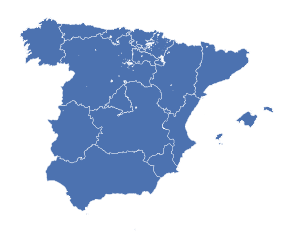

In [134]:
ax = spain_without_canary_by_admin.plot()
ax.set_axis_off();

# Plots and tables

## Type news - Right/Wrong

In [7]:
count_type_news_answer = pd.crosstab(df_news['type_news'], df_news['answer'])
# Rename the index
count_type_news_answer = count_type_news_answer.rename(index={'fake_news': "Misinformation", 
                                                              'true_news': "Legitimate information"})
count_type_news_answer.index = count_type_news_answer.index.rename('Type of news')
count_type_news_answer.to_csv('./tables/type_news_answer_count.csv', index=True)
count_type_news_answer

answer,Right,Wrong
Type of news,,
Misinformation,538,302
Legitimate information,570,270


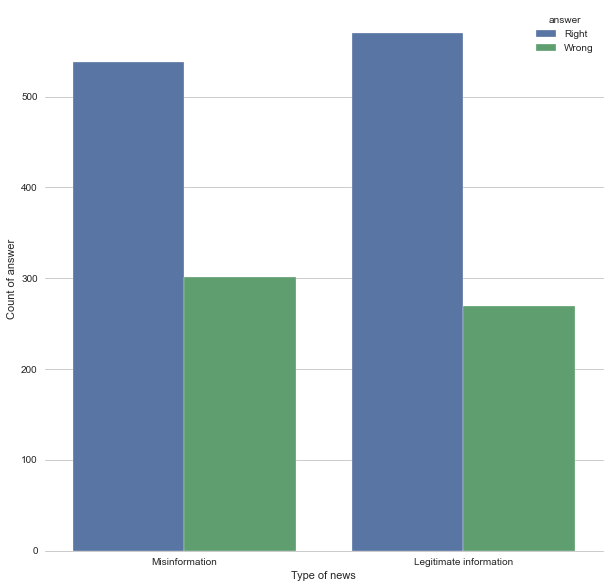

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
x_labels = ['Misinformation', 'Legitimate information']

sns.countplot(hue="answer", x='type_news',  data=df_news, ax=ax,)

ax.set_xticklabels(x_labels)
ax.set(xlabel='Type of news', ylabel='Count of answer')

ax.yaxis.grid(True, clip_on=False)                                                 
sns.despine(left=True, bottom=True)    

fig.savefig('./plots/right_wrong_per_type.svg', format='svg', bbox_inches='tight')
fig.savefig('./plots/right_wrong_per_type.png', format='png', bbox_inches='tight')
plt.show()

A Chisquare test did not show influence of the nature of the news and the capacity for the subjects to correctly identify them X^2(1, N=1680)= 2.54, p=.11.

In [9]:
type_news_chisquare = chisq_posthoc_corrected(pd.crosstab(df_news['type_news'], df_news['answer']))
type_news_chisquare.to_csv('./tables/type_news_chisquare.csv', index=False)
type_news_chisquare

Chi2 result of the contingency table: 2.5473984499255256, p-value: 0.11047603270261172, dof: 1, N: 1680



,type_news,answer,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,fake_news,Right,-1.647543,0.099447,0.397786,False,ns
1,fake_news,Wrong,1.647543,0.099447,0.397786,False,ns
2,true_news,Right,1.647543,0.099447,0.397786,False,ns
3,true_news,Wrong,-1.647543,0.099447,0.397786,False,ns


## News titles - Right/ Wrong

In [10]:
crosstab_news_titles = pd.crosstab(df_news['news_title'], df_news['answer'])
crosstab_news_titles.to_csv('./tables/news_titles_right_wrong_count.csv', index=True)
crosstab_news_titles

answer,Right,Wrong
news_title,,
Alimentos que más inmunizan contra el coronavirus,40,36
Bill Gates anuncia que implantará microchips para combatir Covid-19 y rastrear las vacunas,66,23
Coronavirus | No hay evidencia de que los perros transmitan el virus,55,21
Coronavirus: llega a Madrid el material sanitario al que Huawei se comprometió con el rey Felipe VI,54,46
Demuestran científicamente la relación causal entre la tecnologia 5G y el COVID-19,51,14
El CSIC busca una vacuna para el Covid-19 a partir del virus que erradicó la viruela,60,20
"El Ministerio del Interior alemán define al coronavirus como ""falsa alarma global"" en un informe filtrado a la prensa",58,20
El coronavirus solo se desactiva por completo a más de 90 grados,52,42
El uso de la mascarilla agrava el aislamiento de las personas sordas,75,12


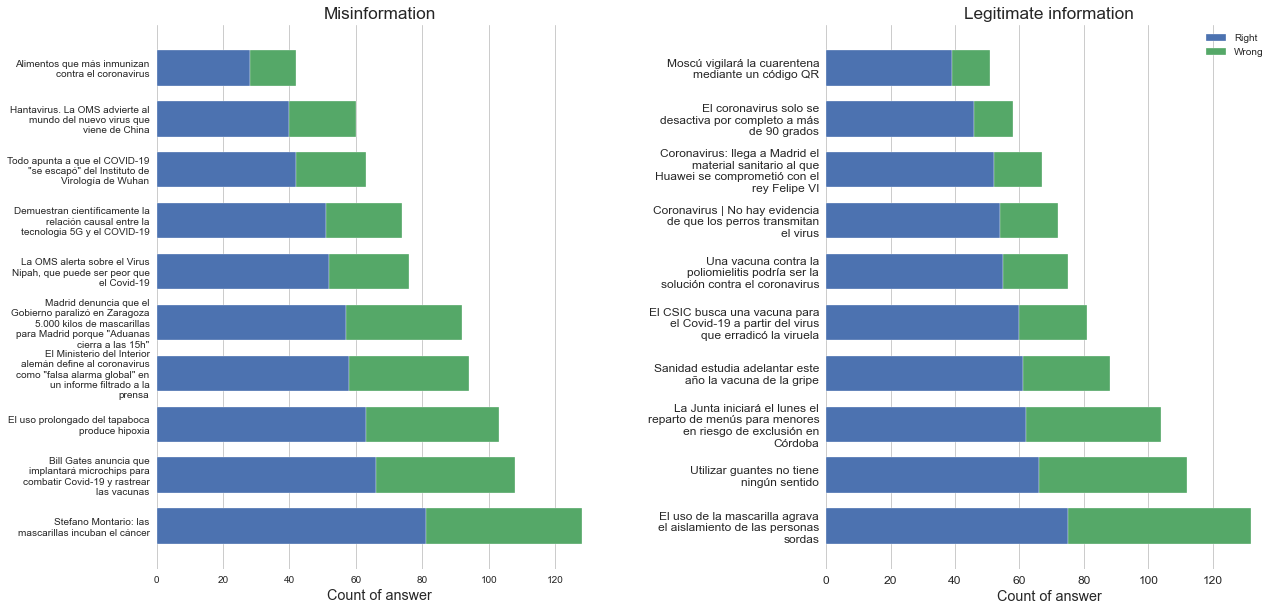

In [11]:
#to_plot = df_news[['answer', 'news_title', 'type_news']].value_counts().to_frame().reset_index()#.rename(columns={'Answer', 'News Title', 'Type of News', 'Count'})
fig, axes = plt.subplots(1,2,figsize=(20,10))
axes = axes.flatten()
type_news = ['fake_news', 'true_news']
for type_ ,ax in zip(type_news,axes):
    #to_plot = df_news[df_news.type_news==type_][['news_title','answer']].value_counts().sort_values(ascending=False)
    
    to_plot = df_news[df_news.type_news==type_][['answer', 'news_title', 'type_news']].value_counts().to_frame().reset_index()
    
    
    labels = to_plot['news_title'].unique()
    labels = [ '\n'.join(wrap(l, 30)) for l in labels ]
    count_right = to_plot[to_plot['answer'] == 'Right'][0]
    count_wrong = to_plot[to_plot['answer'] == 'Wrong'][0]
    width = 0.7

    ax.barh(labels, count_right, width, label='Right')
    ax.barh(labels, count_wrong, width, left=count_right,
           label='Wrong')
    ax.set_xlabel("Count of answer", fontsize='x-large')
    ax.set_ylabel('', fontsize='x-large') 
    
    if type_ == 'fake_news':
        title_plot = 'Misinformation'
    elif type_ == 'true_news':
        title_plot = 'Legitimate information'
    else:
        raise
    ax.set_title(title_plot, fontdict={'fontsize': 'xx-large'})
    ax.yaxis.grid(False)                                                 

    plt.xticks(fontsize='large')
    plt.yticks(fontsize='large')
plt.legend()
fig.subplots_adjust(wspace=.5)    
fig.savefig('./plots/right_wrong_per_news.svg', format='svg', bbox_inches='tight')
fig.savefig('./plots/right_wrong_per_news.png', format='png', bbox_inches='tight')    
    
    #df.unstack().plot.barh(ax=ax, stacked=True)

There is difference between the news about receiving a right or a wrong answers, some news got a fairly balanced answers, while some are more imbalanced in one way or the other. 

## Socio-demographic information

### Gender

In [12]:
gender_count = df_subject['Gender'].value_counts().to_frame().reset_index().rename(columns={'index': 'Gender', 'Gender': "Count"})
#gender_count = gender_count.replace({"Femenino": "Female", 'Masculino': "Male"})
gender_count.to_csv('./tables/gender_counts.csv', index=False)
gender_count

,Gender,Count
0,Female,445
1,Male,395


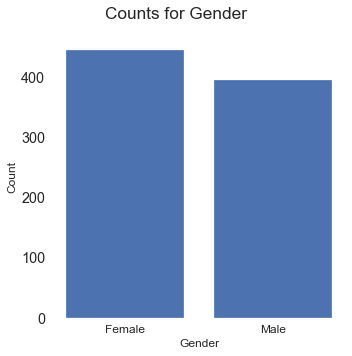

In [13]:
fig, ax = plt.subplots()
ax.bar(gender_count['Gender'], gender_count['Count'])

ax.set_xlabel("Gender", fontsize='large')
ax.set_ylabel('Count', fontsize='large') 



ax.yaxis.grid(False)   
ax.xaxis.grid(False)                                                 


plt.xticks(fontsize='large')
plt.yticks(fontsize='x-large')



plt.suptitle('Counts for Gender', fontsize='xx-large')


plt.tight_layout()


fig.savefig('./plots/gender_count.svg', format='svg', bbox_inches='tight')
fig.savefig('./plots/gender_count.png', format='png', bbox_inches='tight')
plt.show()

### Education

In [14]:
education_count = df_subject['Education'].value_counts().to_frame().reset_index().rename(columns={'index': 'Education', 'Education': "Count"})
#.replace({"University_studies": "University level", 'No_university_studies': "No University level"})
education_count.to_csv('./tables/education_counts.csv', index=False)
education_count

,Education,Count
0,University studies,451
1,No university studies,388


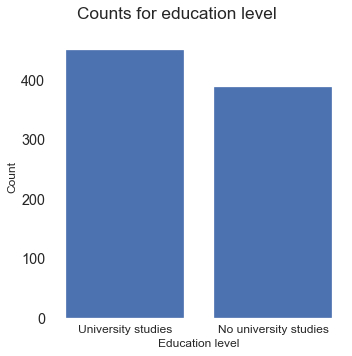

In [15]:
fig, ax = plt.subplots()

ax.bar(education_count['Education'], education_count['Count'])

ax.set_xlabel("Education level", fontsize='large')
ax.set_ylabel('Count', fontsize='large') 



ax.yaxis.grid(False)   
ax.xaxis.grid(False)                                                 


plt.xticks(fontsize='large')
plt.yticks(fontsize='x-large')



plt.suptitle('Counts for education level', fontsize='xx-large')



plt.tight_layout()
fig.savefig('./plots/education_counts.svg', format='svg', bbox_inches='tight')
fig.savefig('./plots/education_counts.png', format='png', bbox_inches='tight')

plt.show()

In [16]:
education2 = df_subject['Education2'].value_counts().to_frame().reset_index().rename(columns={'index': 'Education', 'Education2': "Count"})
#.replace({"University_studies": "University level", 'No_university_studies': "No University level"})


sorter = ["Secondary", "College", "University"]
education2.Education = education2.Education.astype("category")

education2.Education.cat.set_categories(sorter, inplace=True)
education2 = education2.sort_values('Education')
education2.to_csv('./tables/education2_counts.csv', index=False)
education2

,Education,Count
2,Secondary,156
1,College,232
0,University,451


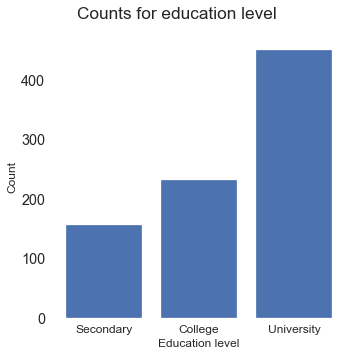

In [17]:
fig, ax = plt.subplots()

ax.bar(education2['Education'], education2['Count'])

ax.set_xlabel("Education level", fontsize='large')
ax.set_ylabel('Count', fontsize='large') 



ax.yaxis.grid(False)   
ax.xaxis.grid(False)                                                 


plt.xticks(fontsize='large')
plt.yticks(fontsize='x-large')



plt.suptitle('Counts for education level', fontsize='xx-large')



plt.tight_layout()
fig.savefig('./plots/education2_counts.svg', format='svg', bbox_inches='tight')
fig.savefig('./plots/education2_counts.png', format='png', bbox_inches='tight')

plt.show()

### Age 

In [18]:
age_count = df_subject['Age'].value_counts().to_frame().reset_index().rename(columns={'index': 'Age', 'Age': "Count"})
#gender_count = gender_count.replace({"University_studies": "University level", 'No_university_studies': "No University level"})
sorter = ["<=18-34", "35-54", ">55"]
age_count.Age = age_count.Age.astype("category")

age_count.Age.cat.set_categories(sorter, inplace=True)
age_count = age_count.sort_values('Age')
age_count.to_csv('./tables/age_counts.csv', index=False)
age_count

,Age,Count
2,<=18-34,201
0,35-54,422
1,>55,217


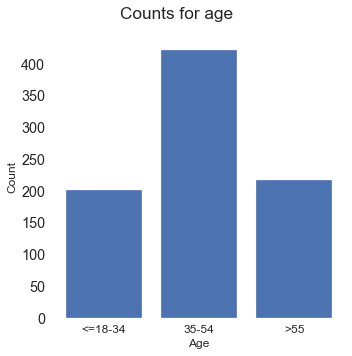

In [19]:
fig, ax = plt.subplots()

ax.bar(age_count['Age'], age_count['Count'])

ax.set_xlabel("Age", fontsize='large')
ax.set_ylabel('Count', fontsize='large') 



ax.yaxis.grid(False)   
ax.xaxis.grid(False)                                                 


plt.xticks(fontsize='large')
plt.yticks(fontsize='x-large')



plt.suptitle('Counts for age', fontsize='xx-large')



plt.tight_layout()
fig.savefig('./plots/age_counts.svg', format='svg', bbox_inches='tight')
fig.savefig('./plots/age_counts.png', format='png', bbox_inches='tight')

plt.show()

### Technological knowledge


In [20]:
techno_count = df_subject['Technological'].value_counts().to_frame().reset_index().rename(columns={'index': 'Technological knowledge', 'Technological': "Count"})
#gender_count = gender_count.replace({"Avanzada": "Advanced", 'Media': "Intermediary", "Básica": "Basic"})


sorter = ["Basic", "Intermediate", "Advanced"]
techno_count["Technological knowledge"] = techno_count["Technological knowledge"].astype("category")

techno_count["Technological knowledge"].cat.set_categories(sorter, inplace=True)
techno_count = techno_count.sort_values("Technological knowledge")


techno_count.to_csv('./tables/tech_level_counts.csv', index=False)
techno_count

,Technological knowledge,Count
2,Basic,74
1,Intermediate,363
0,Advanced,400


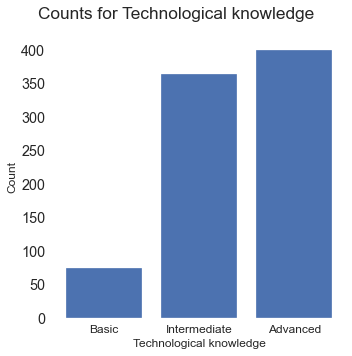

In [21]:
fig, ax = plt.subplots()

ax.bar(techno_count['Technological knowledge'], techno_count['Count'])

ax.set_xlabel("Technological knowledge", fontsize='large')
ax.set_ylabel('Count', fontsize='large') 



ax.yaxis.grid(False)   
ax.xaxis.grid(False)                                                 


plt.xticks(fontsize='large')
plt.yticks(fontsize='x-large')



plt.suptitle('Counts for Technological knowledge', fontsize='xx-large')



plt.tight_layout()
fig.savefig('./plots/tech_level_counts.svg', format='svg', bbox_inches='tight')
fig.savefig('./plots/tech_level_counts.png', format='png', bbox_inches='tight')

plt.show()

### Religion

In [22]:
religion_count = df_subject['Religion'].value_counts().to_frame().reset_index().rename(columns={'index': 'Religion', 'Religion': "Count"})
#gender_count = gender_count.replace({"University_studies": "University level", 'No_university_studies': "No University level"})
religion_count.to_csv('./tables/religion_counts.csv', index=False)
religion_count

,Religion,Count
0,Religious,420
1,No religious,334


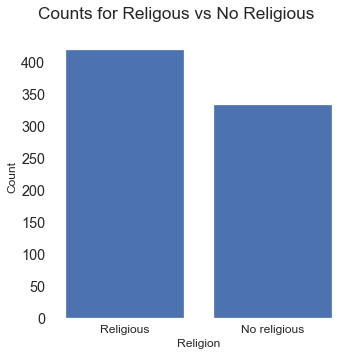

In [23]:
fig, ax = plt.subplots()

ax.bar(religion_count['Religion'], religion_count['Count'])

ax.set_xlabel("Religion", fontsize='large')
ax.set_ylabel('Count', fontsize='large') 



ax.yaxis.grid(False)   
ax.xaxis.grid(False)                                                 


plt.xticks(fontsize='large')
plt.yticks(fontsize='x-large')



plt.suptitle('Counts for Religous vs No Religious', fontsize='xx-large')



plt.tight_layout()
fig.savefig('./plots/religion_counts.svg', format='svg', bbox_inches='tight')
fig.savefig('./plots/religion_counts.png', format='png', bbox_inches='tight')

plt.show()

### Politics

In [24]:
politic_count = df_subject['Political'].value_counts().to_frame().reset_index().rename(columns={'index': 'Political alignment', 'Political': "Count"})
#gender_count = gender_count.replace({"Izquierda": "Left", 'Derecha': "Right", "Centro": "Centre"})


sorter = ["Left", "Centre", "Right"]
politic_count["Political alignment"] = politic_count["Political alignment"].astype("category")

politic_count["Political alignment"].cat.set_categories(sorter, inplace=True)
politic_count = politic_count.sort_values("Political alignment")

politic_count.to_csv('./tables/politic_counts.csv', index=False)
politic_count

,Political alignment,Count
0,Left,351
2,Centre,135
1,Right,164


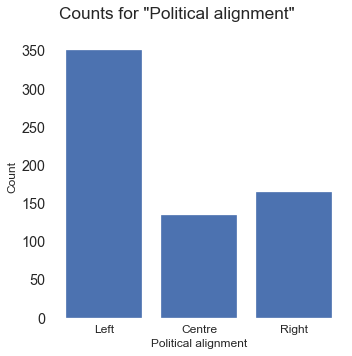

In [25]:
fig, ax = plt.subplots()

ax.bar(politic_count["Political alignment"], politic_count['Count'])

ax.set_xlabel("Political alignment", fontsize='large')
ax.set_ylabel('Count', fontsize='large') 



ax.yaxis.grid(False)   
ax.xaxis.grid(False)                                                 


plt.xticks(fontsize='large')
plt.yticks(fontsize='x-large')



plt.suptitle('Counts for "Political alignment"', fontsize='xx-large')



plt.tight_layout()
fig.savefig('./plots/politic_counts.svg', format='svg', bbox_inches='tight')
fig.savefig('./plots/politic_counts.png', format='png', bbox_inches='tight')

plt.show()

### All socio-demo at the same time

In [28]:
all_socio = {'Gender': gender_count, 'Education level': education_count, 
              'Religious vs non religious': religion_count, 
              'Political alignement': politic_count, 
              'Technological knowledge': techno_count, 
               'Age': age_count}

SyntaxError: unmatched ')' (<ipython-input-28-d7964bedc0d3>, line 6)

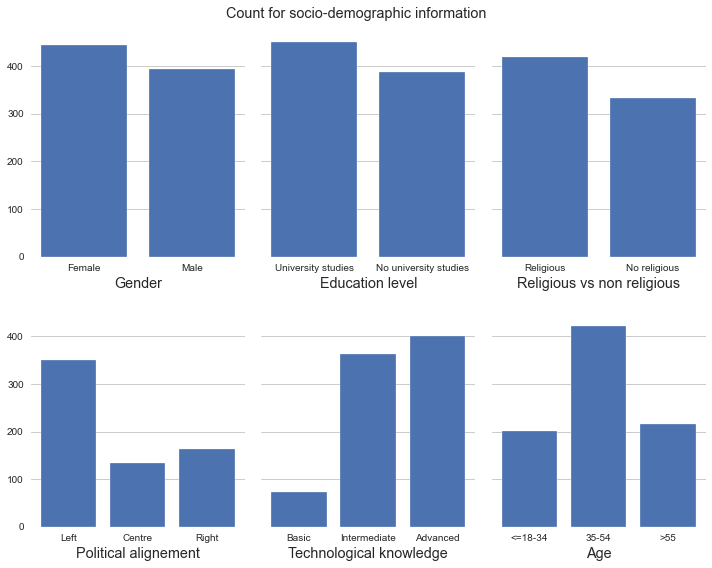

In [64]:
fig, ax = plt.subplots(2, 3, sharey=True, figsize=(10, 8))
fig.suptitle('Count for socio-demographic information', fontsize='x-large')

for indx, k in enumerate(all_socio):
    if indx<=2:
        ax_y = indx
        ax_x = 0
    else:
        ax_y = indx-3
        ax_x = 1

        
    ax[ax_x, ax_y].bar(all_socio[k].iloc[:,0], all_socio[k].iloc[:,1])

    ax[ax_x, ax_y].set_xlabel(k, fontsize='x-large')
    #ax[ax_x, ax_y].set_ylabel('Count', fontsize='large') 

for ax in fig.get_axes():
    #ax.yaxis.grid(False)   
    ax.xaxis.grid(False)  
    #ax.label_outer()
plt.tight_layout()
fig.savefig('./plots/all_socio-demo.svg', format='svg', bbox_inches='tight')
fig.savefig('./plots/all_socio-demo.png', format='png', bbox_inches='tight')

plt.show()

In [ ]:
politic_count = df_subject['Political'].value_counts().to_frame().reset_index().rename(columns={'index': 'Political alignment', 'Political': "Count"})
#gender_count = gender_count.replace({"Izquierda": "Left", 'Derecha': "Right", "Centro": "Centre"})


sorter = ["Left", "Centre", "Right"]
politic_count["Political alignment"] = politic_count["Political alignment"].astype("category")

politic_count["Political alignment"].cat.set_categories(sorter, inplace=True)
politic_count = politic_count.sort_values("Political alignment")

politic_count.to_csv('./tables/politic_counts.csv', index=False)
politic_count






## Justifications

In [ ]:
# Justification columns


var_just_fake = ["Previously_read_debunked",
                 "Source_unknown",
                 "Media_unreliable",
                 "Cited_sources_unknown",
                 "Cited_sources_unreliable",
                 "Without_sources",
                 "Unprofessional_style",
                 "No_coherent",
                 "Headline_sensationalist",
                 "Image_sensationalist",
                 "Different_belief",
                 "Different_ideology",
                 "Other"]

var_just_true = ["Previously_read_the_information",
                 "Known_media",
                 "Reliable_media",
                 "Source_known",
                 "Source_Reliable",
                 "Professional_style",
                 "Coherent",
                 "Same_belief",
                 "Same_ideology",
                 "Other"]

## Creating mask to sample only when Participants were presented the Justification right and Justification wrong


In [ ]:
# Melting the different justifications 
df_new_to_plot_right = pd.melt(df_news, id_vars= ['answer', 'type_news', 'id_sondea', 'news_title'], value_vars=[*var_just_true ])
#Rename the justification to be the same 

#df_new_to_plot_right['variable'] = df_new_to_plot_right['variable'].str[4:]

mask_justification_right = (((df_new_to_plot_right['type_news'] == 'true_news') & (df_new_to_plot_right['answer'] == 'Right')) | ((df_new_to_plot_right['type_news'] == 'fake_news') & (df_new_to_plot_right['answer'] == 'Wrong')))
df_new_to_plot_right = df_new_to_plot_right[mask_justification_right].copy()

# Replacing the answer 'otro' by True rather than keeping the name
special_answers = ~df_new_to_plot_right.value.isin([True, False, np.NaN])
df_new_to_plot_right.loc[special_answers, 'value'] = True

In [ ]:
to_plot = df_new_to_plot_right.groupby(by=['variable', 'answer', 'type_news'])['value'].sum().to_frame().reset_index()#.rename(columns=['Justification', 'answer', 'type_news', 'count'])
# Filtering only the justification right
mask_justification_right = (((to_plot['type_news'] == 'true_news') & (to_plot['answer'] == 'Right')) | ((to_plot['type_news'] == 'fake_news') & (to_plot['answer'] == 'Wrong')))
to_plot = to_plot[mask_justification_right]
# Reorder plot based on the right answer
to_plot = to_plot.sort_values(by=['answer', 'value'])
to_plot

In [ ]:
# Melting the different justifications 
df_new_to_plot_wrong = pd.melt(df_news, id_vars= ['answer', 'type_news', 'id_sondea', 'news_title'], value_vars=[*var_just_fake ])
#Rename the justification to be the same 

# Replacing the answer 'otro' by True rather than keeping the name
special_answers = ~df_new_to_plot_wrong.value.isin([True, False, np.NaN])
df_new_to_plot_wrong.loc[special_answers, 'value'] = True

### Justifications when the subject think it is misinformation

In [ ]:
to_plot = df_new_to_plot_wrong.groupby(by=['variable', 'answer', 'type_news'])['value'].sum().to_frame().reset_index()#.rename(columns=['Justification', 'answer', 'type_news', 'count'])
# Filtering only the justification right
mask_justification_wrong = (((to_plot['type_news'] == 'true_news') & (to_plot['answer'] == 'Wrong')) | ((to_plot['type_news'] == 'fake_news') & (to_plot['answer'] == 'Right')))
to_plot = to_plot[mask_justification_wrong]
# Reorder plot based on the right answer
to_plot = to_plot.sort_values(by=['answer', 'value'])
to_plot

In [ ]:
labels = to_plot['variable'].unique()
count_right = to_plot[to_plot['type_news'] == 'fake_news']['value']
count_wrong = to_plot[to_plot['type_news'] == 'true_news']['value']
width = 0.5
fig, ax = plt.subplots()

ax.barh(labels, count_right, width, label='Right')
ax.barh(labels, count_wrong, width, left=count_right,
      label='Wrong')
ax.set_xlabel("Count of answers", fontsize='large')
ax.set_ylabel('Justification', fontsize='large') 


ax.yaxis.grid(False)   
ax.xaxis.grid(False)                                                 


plt.xticks(fontsize='large')
plt.yticks(fontsize='x-large')


plt.tight_layout()
plt.legend()

plt.suptitle('Justification when Subject thinks it is misinformation', fontsize=16)
fig.savefig('./plots/justification_fake_news.svg', format='svg', bbox_inches='tight')
fig.savefig('./plots/justification_fake_news.png', format='png', bbox_inches='tight')

plt.show()

### Justifications when the subject thinks it is a True news

In [ ]:
to_plot = df_new_to_plot_right.groupby(by=['variable', 'answer', 'type_news'])['value'].sum().to_frame().reset_index()#.rename(columns=['Justification', 'answer', 'type_news', 'count'])
# Filtering only the justification right
mask_justification_wrong = (((to_plot['type_news'] == 'true_news') & (to_plot['answer'] == 'Right')) | ((to_plot['type_news'] == 'fake_news') & (to_plot['answer'] == 'Wrong')))
to_plot = to_plot[mask_justification_wrong]
# Reorder plot based on the right answer
to_plot = to_plot.sort_values(by=['answer', 'value'])
to_plot

In [ ]:
labels = to_plot['variable'].unique()
count_right = to_plot[to_plot['type_news'] == 'fake_news']['value']
count_wrong = to_plot[to_plot['type_news'] == 'true_news']['value']
width = 0.5
fig, ax = plt.subplots()

ax.barh(labels, count_right, width, label='Wrong')
ax.barh(labels, count_wrong, width, left=count_right,
      label='Right')
ax.set_xlabel("Count of answers", fontsize='large')
ax.set_ylabel('Justification', fontsize='large') 


ax.yaxis.grid(False)   
ax.xaxis.grid(False)                                                 


plt.xticks(fontsize='large')
plt.yticks(fontsize='x-large')
plt.tight_layout()

plt.legend()
#plt.legend(labels=["Right answer","Wrong answer"], fontsize='medium')

plt.suptitle('Justification when Subject thinks it is legitimate information', fontsize=16)
fig.savefig('./plots/justification_right_news.svg', format='svg', bbox_inches='tight')
fig.savefig('./plots/justification_right_news.png', format='png', bbox_inches='tight')

plt.show()

### Justification, people getting wrong on Misinformation

In [ ]:
# Filtering only the justification right
mask_justification_fake_wrong = (((df_new_to_plot_right['type_news'] == 'fake_news') & (df_new_to_plot_right['answer'] == 'Wrong')))
to_plot = df_new_to_plot_right[mask_justification_fake_wrong]

to_plot = to_plot.groupby(by=['variable', 'answer', 'type_news'])['value'].sum().to_frame().reset_index()#.rename(columns=['Justification', 'answer', 'type_news', 'count'])

# Reorder plot based on the right answer
to_plot = to_plot.sort_values(by=['answer', 'value']).drop(columns=['answer', 'type_news'])
to_plot

In [ ]:
width = 0.5
fig, ax = plt.subplots()
labels = to_plot['variable']
counts = to_plot['value']
ax.barh(labels, counts, width, label='Wrong')

ax.set_xlabel("Count of answers", fontsize='large')
ax.set_ylabel('Justification', fontsize='large') 


#ax.yaxis.grid(False)   
ax.xaxis.grid(False)                                                 


plt.xticks(fontsize='large')
plt.yticks(fontsize='x-large')

#plt.legend(labels=["Right answer","Wrong answer"], fontsize='medium')

plt.suptitle('Justification when subject consider a Misinformation as Legitimate', fontsize=16)

#plt.tight_layout()

fig.savefig('./plots/justification_fake_wrong.svg', bbox_inches='tight')
fig.savefig('./plots/justification_fake_wrong.png', bbox_inches='tight')

plt.show()

In [ ]:
df_new_to_plot_right[mask_justification_fake_wrong]['id_sondea'].unique().size

 ### Justification, people getting right on Legitimate information

In [ ]:
# Filtering only the justification right
mask_justification_true_right = (((df_new_to_plot_right['type_news'] == 'true_news') & (df_new_to_plot_right['answer'] == 'Right')))
to_plot = df_new_to_plot_right[mask_justification_true_right]

to_plot = to_plot.groupby(by=['variable', 'answer', 'type_news'])['value'].sum().to_frame().reset_index()#.rename(columns=['Justification', 'answer', 'type_news', 'count'])

# Reorder plot based on the right answer
to_plot = to_plot.sort_values(by=['answer', 'value']).drop(columns=['answer', 'type_news'])
to_plot

In [ ]:
width = 0.5
fig, ax = plt.subplots()
labels = to_plot['variable']
counts = to_plot['value']
ax.barh(labels, counts, width, label='Wrong')

ax.set_xlabel("Count of answers", fontsize='large')
ax.set_ylabel('Justification', fontsize='large') 


#ax.yaxis.grid(False)   
ax.xaxis.grid(False)                                                 


plt.xticks(fontsize='large')
plt.yticks(fontsize='x-large')

#plt.legend(labels=["Right answer","Wrong answer"], fontsize='medium')

plt.suptitle('Justification when subject consider a Legitimate as Legitimate', fontsize=16)

#plt.tight_layout()

fig.savefig('./plots/justification_true_right.svg', bbox_inches='tight')
fig.savefig('./plots/justification_true_right.png', bbox_inches='tight')

plt.show()

In [ ]:
df_new_to_plot_right[mask_justification_true_right]['id_sondea'].unique().size

### Justification, people getting Right on Misinformation

In [ ]:
# Filtering only the justification right
mask_justification_fake_right = (((df_new_to_plot_wrong['type_news'] == 'fake_news') & (df_new_to_plot_wrong['answer'] == 'Right')))
to_plot = df_new_to_plot_wrong[mask_justification_fake_right]

to_plot = to_plot.groupby(by=['variable', 'answer', 'type_news'])['value'].sum().to_frame().reset_index()#.rename(columns=['Justification', 'answer', 'type_news', 'count'])

# Reorder plot based on the right answer
to_plot = to_plot.sort_values(by=['answer', 'value']).drop(columns=['answer', 'type_news'])
to_plot

In [ ]:
width = 0.5
fig, ax = plt.subplots()
labels = to_plot['variable']
counts = to_plot['value']
ax.barh(labels, counts, width, label='Wrong')

ax.set_xlabel("Count of answers", fontsize='large')
ax.set_ylabel('Justification', fontsize='large') 


#ax.yaxis.grid(False)   
ax.xaxis.grid(False)                                                 


plt.xticks(fontsize='large')
plt.yticks(fontsize='x-large')

#plt.legend(labels=["Right answer","Wrong answer"], fontsize='medium')

plt.suptitle('Justification when subject consider a Misinformation as Misinformation', fontsize=16)

#plt.tight_layout()

fig.savefig('./plots/justification_fake_right.svg', format='svg', bbox_inches='tight')
fig.savefig('./plots/justification_fake_right.png', format='png', bbox_inches='tight')

plt.show()

### Justification, people getting Wrong on Misinformation

In [ ]:
# Filtering only the justification right
mask_justification_true_wrong = (((df_new_to_plot_wrong['type_news'] == 'true_news') & (df_new_to_plot_wrong['answer'] == 'Wrong')))
to_plot = df_new_to_plot_wrong[mask_justification_true_wrong]

to_plot = to_plot.groupby(by=['variable', 'answer', 'type_news'])['value'].sum().to_frame().reset_index()#.rename(columns=['Justification', 'answer', 'type_news', 'count'])

# Reorder plot based on the right answer
to_plot = to_plot.sort_values(by=['answer', 'value']).drop(columns=['answer', 'type_news'])
to_plot

In [ ]:
width = 0.5
fig, ax = plt.subplots()
labels = to_plot['variable']
counts = to_plot['value']
ax.barh(labels, counts, width, label='Wrong')

ax.set_xlabel("Count of answers", fontsize='large')
ax.set_ylabel('Justification', fontsize='large') 


#ax.yaxis.grid(False)   
ax.xaxis.grid(False)                                                 


plt.xticks(fontsize='large')
plt.yticks(fontsize='x-large')

#plt.legend(labels=["Right answer","Wrong answer"], fontsize='medium')

plt.suptitle('Justification when subject consider a Legitimate information as Misinformation', fontsize=16)

#plt.tight_layout()

fig.savefig('./plots/justification_true_wrong.svg', format='svg', bbox_inches='tight')
fig.savefig('./plots/justification_true_wrong.png', format='png', bbox_inches='tight')

plt.show()

## Actions

In [ ]:
var_actions = ['share_friends_and_family', 
               'share_online', 
               'verify_source', 
               "apply_learning", 
               'no_action']

In [ ]:
# Melting the different justifications 
df_new_to_plot_action = pd.melt(df_news, id_vars= ['answer', 'type_news', 'id_sondea', 'news_title'], value_vars=[*var_actions])
#Rename the justification to be the same 
mask_action = (((df_new_to_plot_action['type_news'] == 'true_news') & (df_new_to_plot_action['answer'] == 'Right')) | ((df_new_to_plot_action['type_news'] == 'fake_news') & (df_new_to_plot_action['answer'] == 'Wrong')))
df_new_to_plot_action_filtered = df_new_to_plot_action[mask_action].copy()
#df_new_to_plot_right_filtered['variable'] = df_new_to_plot_right_filtered['variable'].str[4:]

#df_new_to_plot_right['variable'] = np.where(df_new_to_plot_right['value']== 1, df_new_to_plot_right['variable'],np.NaN )
df_new_to_plot_action_filtered

In [ ]:
to_plot = df_new_to_plot_action_filtered.groupby(by=['variable', 'answer', 'type_news'])['value'].sum().to_frame().reset_index()#.rename(columns=['Justification', 'answer', 'type_news', 'count'])
# Filtering only the justification TR or FW
mask_action = (((to_plot['type_news'] == 'true_news') & (to_plot['answer'] == 'Right')) | ((to_plot['type_news'] == 'fake_news') & (to_plot['answer'] == 'Wrong')))

to_plot = to_plot[mask_action].copy()
to_plot

In [ ]:
labels = to_plot['variable'].unique()

count_right = to_plot[to_plot['type_news'] == 'true_news']['value']
count_wrong = to_plot[to_plot['type_news'] == 'fake_news']['value']

In [ ]:
to_plot = to_plot.sort_values(by=['answer', 'value'])
labels = to_plot['variable'].unique()
count_right = to_plot[to_plot['type_news'] == 'fake_news']['value']
count_wrong = to_plot[to_plot['type_news'] == 'true_news']['value']
width = 0.5
fig, ax = plt.subplots()

ax.barh(labels, count_right, width, label='Right')
ax.barh(labels, count_wrong, width, left=count_right,
      label='Wrong')
ax.set_xlabel("Count of answers", fontsize='large')
ax.set_ylabel('Actions', fontsize='large') 

ax.yaxis.grid(False)   
ax.xaxis.grid(False)                                                 


plt.xticks(fontsize='large')
plt.yticks(fontsize='x-large')


#plt.legend(labels=["Right answer","Wrong answer"], fontsize='large')
plt.legend()
plt.suptitle('Actions when subject thinks it is legitimate information', fontsize=18)
#plt.tight_layout()
fig.savefig('./plots/action_true_news.svg', format='svg')
fig.savefig('./plots/action_true_news.png', format='png')

plt.show()